In [1]:
import os
os.chdir('C:\\Users\\HP\\OneDrive\\Desktop\\Akaike\\Basics')
os.getcwd()

'C:\\Users\\HP\\OneDrive\\Desktop\\Akaike\\Basics'

In [2]:
import pandas as pd
import math
import numpy as np
import json
from dotenv import load_dotenv
import re
import copy
import plotly.graph_objects as go
from langchain_community.chat_models import  ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage
load_dotenv(".env")

True

In [3]:
from langchain.schema import HumanMessage, SystemMessage
from langchain_community.chat_models import AzureChatOpenAI, ChatOpenAI
from loguru import logger

In [4]:
def model_response(query: str):
    chat = ChatOpenAI(model="gpt-4o",
                      openai_api_key=os.environ['OPENAI_API_KEY'],
                      temperature=0,
                      model_kwargs={
                          "response_format": {"type": "json_object"},
                          "seed": 42})

    messages = [
        SystemMessage(
            content="You are a business analyst designed to give key insights,designed to output json"),
        HumanMessage(
            content=query),
    ]
    return json.loads(chat(messages).content)

In [5]:
def give_chart_type(question: str, dfs_head) -> str:
    prompt = '''
    Given the following set heads of the datasetand the query:
    There are three types of query classifications for visualization:

    time_series: Analyzing time series trends. Graph type: Line.
    Example: 1."Give me sales trend."
             2."Sales from July to october"
    group_aggregates: Analyzing over different product categories. Graph types: Bar, Pie,stacked_bar
    Example:1. "Give me sales for each product category."
            2. "Give me sales for product category A and Product category B"
            3. Give me count per product category
    combination: A combination of time_series and group_aggregates.Where query is requoring Analysis of time series trends for each group category. Graph type: multiline.
    Example: 1.Give me product wise sales trend ,
             2. sales trend for each vehicle_type
    multilevel_categorical: Analyze trend where there is a split at 2 levels
    Example: 1. Show me the quantity sold by Product category breakdown by gender
             2. Show me the average profits generated by each product category segmented by customer login type

    Result Format:{{
    "is_chart_possible": "Yes/No (if the query is related to the head of the dataset, then Yes; else, No)",
    "tables": ["list of tables required for the visualization"],
    "chart_type": type of chart suitable for this visualization(like line/multiline/bar/pie etc.)"}}
    only return the result dict, I must be directly able to convert it to json

    **Important Instruction**
    
    - is_chart_possible should be no if and only if the visualization for the query is can't be categorized in time_series,group aggregates,combination,multilevel_categorical
    -  Make sure you to give result in the correct format having each key value pair
    - in case user has asked trend over days of the week then consider type  as group aggregates
    ```
    Examples:
    For the given Head of the datasets
    {{'sales_data': ['date','day of the week', 'product_id', 'sales_amount','gender','quantity'],'product_categories': ['product_id','category','cost']}}

    Query: "Give me sales trend."
    Result: {{"is_chart_possible": "Yes","tables": ["sales_data"],"type": "time_series","chart_type": "line"}}

    Query: "Give me profit per product."
    Result: {{"is_chart_possible": "No","tables": [],"type": "","chart_type": ""}}


    Query: "Give me cost for product category lifebuoy and vivel"
    Result: {{"is_chart_possible": "Yes","tables": ["product_categories],"type": "group_aggregates","chart_type": "bar"}}

    Query: "Show me the quantity sold by Product category breakdown by gender"
    Result: {{"is_chart_possible": "Yes","tables": ["sales_data"],"type": "multilevel_categorical","chart_type": "grouped_bar"}}
    
    Query: "Show me sales trend over days of the week"
    Result: {{"is_chart_possible": "Yes","tables": ["sales_data"],"type": "group_aggregates","chart_type": "bar"}}
    
    ```
    Here You Go!
    Head of the datasets(first five rows of the dataset for reference): {dfs_head}
    metadata of the dataset
    query: {question}
    Result:
    '''

    return prompt.format(dfs_head=dfs_head, question=question)

In [6]:
def generate_chart_config(chart_class, question: str, df_head, column_description: str = ""):
    prompt = '''
        For a given query:  on the given  dataset and type of the visualization: , we are required to plot the given visualization , return chart config in the format below:

        chart_config: {{"x_axis":column of the dataset(it should be a column present in the dataset) to be on x_axis for the given visualization,"y_axis":column of the dataset to be on the y_axis,binning:only fill in case of time series or combinations its either yearly or monthly,heading:The heading for the visualization,group_by:column of the dataset on which grouping is to be done(Leave Blank For Time series, make sure it is a column present in the dataset),operation:infer this from the question, it is either mean,max,sum,chart_type:the chart type to be used for visualization(eg. bar/line/multiline)}}
        **Important**
        - Make Sure x and y axis values are present in the columns of the dataset
        - binning parameter is mandatory for time series and combination types
        - if user has asked data for a period of less than 2 months keep the binning parameter as daily
        - Make sure that Heading is self explainatory of the operation performend
        ```
        Examples:
        Head of the dataset
        date, product_id, sales_amount, category
        21/08/2022, 123, 12233, grocery
        
        Query: "Give me sales trend for each product category."
        Chart Class: {{"chart_type": "multiline", "type": "combination"}}
        Result: {{"x_axis": "date", "y_axis": "sales_amount", "binning": "monthly", "heading": "Total Average Sales Trend for Each Product Category", "group_by": "category", "operation": "mean", "chart_type": "multiline", "start_date": None, "end_date": None}}
        
        Query: "Give me sales for each product category."
        Chart Class: {{"chart_type": "bar", "type": "group_aggregates"}}
        Result: {{"x_axis": "category", "y_axis": "sales_amount", "binning": "", "heading": "Total  Sales for Each Product Category", "group_by": "", "operation": "sum", "chart_type": "bar", "start_date": None, "end_date":None}}
        
        Query: "Give me sales for each product category. from 2018 -2020"
        Chart Class: {{"chart_type": "multiline", "type": "combination"}}
        Result:{{"x_axis": "date", "y_axis": "sales_amount", "binning": "monthly", "heading": "Total Monthly Sales Trend for Each Product Category", "group_by": "category", "operation": "sum", "chart_type": "multiline", "start_date": "2018-01-01", "end_date": "2020-12-31"}}

        Query: "Give me count for each product category."
        Chart Class: {{"chart_type": "bar", "type": "group_aggregates"}}
        Result: {{"x_axis": "category", "y_axis": "category", "binning": "", "heading": "Count per product Product Category", "group_by": "", "operation": "count", "chart_type": "bar", "start_date": None, "end_date":None}}
        ```
        column descriptions : {column_description} (if empty use your understanding of data)
        Head of the dataset: {df_head}
        Query:{question}
        chart_class:{chart_class}
        Result:
        '''
    return prompt.format(df_head=df_head, question=question, chart_class=chart_class,
                         column_description=column_description)



In [7]:
class PandasResultantDataframe:
    '''
    class to execute required pandas code
    '''

    def __init__(self, chart_config, df,filter_columns):
        self.chart_config = chart_config
        self.df2 = df
        self.freq_dict = {'business_day': 'B', 'calendar_day': 'D', 'weekly': 'W', 'monthly': 'M', 'quarterly': 'Q',
                          'yearly': 'A', 'hourly': 'H', 'minutely': 'T', 'secondly': 'S', 'milliseconds': 'L',
                          'microseconds': 'U', 'nanoseconds': 'N'}
        self.filter_columns = filter_columns
    def _apply_filters(self,df):
      
        # Apply filters for numerical columns
        for col, conditions in self.filter_columns.get('numerical_columns', {}).items():
            start_value = conditions.get('start_value')
            end_value = conditions.get('end_value')
            if start_value is not None:
                df = df[df[col] >= start_value]
            if end_value is not None:
                df = df[df[col] <= end_value]
        
        # Apply filters for date columns
        for col, conditions in self.filter_columns.get('date_columns', {}).items():
            start_date = conditions.get('start_date')
            end_date = conditions.get('end_date')
            if start_date and end_date:
                df[col] = pd.to_datetime(df[col])
                df = df[(df[col] >= pd.to_datetime(start_date)) & (df[col] <= pd.to_datetime(end_date))]
            elif start_date:
                df = df[df[col] >= pd.to_datetime(start_date)]
            elif end_date:
                df = df[df[col] <= pd.to_datetime(end_date)]
        
        # Apply filters for categorical columns
        for col, values in self.filter_columns.get('categorical_columns', {}).items():
            if values:
                df = df[df[col].isin(values)]
        
        return df

    def time_series_resultant_df(self):
        x_axis = self.chart_config['x_axis']
        y_axis = self.chart_config['y_axis'] 
        operation = self.chart_config.get('operation', "mean")
        df1 = self._apply_filters(self.df2.copy())
        if "binning" in self.chart_config.keys():
            binning = self.chart_config['binning']  ## yearly, monthly, daily
            if binning !='':
                binning = 'monthly'
        elif df1.shape[0]> 720:
            binning = 'yearly'
        elif df1.shape[0] >60:
            binning = 'monthly'
        else:
            binning = 'daily'
    
        if df1[x_axis].dtype != "int64":
            df1[x_axis] = pd.to_datetime(df1[x_axis])
            df1[binning] = df1[x_axis].dt.to_period(self.freq_dict[binning]).dt.to_timestamp()
            resultant_df = df1.groupby(binning)[y_axis].agg(operation)
        else:
            resultant_df = df1.groupby(x_axis)[y_axis].agg(operation)
        resultant_df = resultant_df.reset_index()
        resultant_df.columns = [x_axis, y_axis]
        return resultant_df
    # def calculate_num_bins(self,series):
    #     n = len(series)
    #     bin_width = math.sqrt(n)
    #     num_bins = int(np.ceil((series.max() - series.min())/ bin_width))
            
    #     return num_bins
    def calculate_num_bins(self,series):
        q1,q3 = np.percentile(series,[25,75])
        iqr=q3-q1
        # n = len(series)
        # bin_width=(2*iqr)/(n**(1/3))
        num_bins = int((series.max()-series.min())/iqr)
        return num_bins

      
    def group_aggregates_resultant_df(self):
        x_axis = self.chart_config["x_axis"]
        y_axis = self.chart_config["y_axis"]
        operation = self.chart_config.get("operation", "mean")
        df1 = self._apply_filters(self.df2.copy())
        if df1[x_axis].dtype.kind in 'iufc': 
            num_unique_values = df1[x_axis].nunique()
            if num_unique_values > 12:  
                if num_bins is None:
                    num_bins = self.calculate_num_bins(df1[x_axis])

                if x_axis == y_axis:
                    resultant_df = df1.groupby(pd.cut(df1[x_axis], bins=num_bins, precision=0)).size().reset_index(name="count")
                    chart_config["y_axis"] = "count"
                else:
                    resultant_df = df1.groupby(pd.cut(df1[x_axis], bins=num_bins, precision=0)).agg({y_axis: operation}).reset_index()
            else:  
                if x_axis == y_axis:
                    resultant_df = df1.groupby(x_axis).size().reset_index(name="count")
                    chart_config["y_axis"] = "count"
                else:
                    resultant_df = df1.groupby(x_axis)[y_axis].agg(operation).reset_index()
        else:
            if x_axis == y_axis:
                resultant_df = df1.groupby(x_axis).size().reset_index(name="count")
                chart_config["y-axis"] = "count"
            else:
                resultant_df = df1.groupby(x_axis)[y_axis].agg(operation).reset_index()

        return resultant_df

       

    def combination_resultant_df(self):
        chart_config = self.chart_config
        df1 = self._apply_filters(self.df2.copy())
        x_axis = chart_config['x_axis']
        y_axis = chart_config['y_axis']
        group_by = chart_config['group_by']
        if "binning" in self.chart_config.keys():
            binning = self.chart_config['binning']  ## yearly, monthly, daily
            if binning !='':
                binning = 'monthly'
        elif df1.shape[0]> 720:
            binning = 'yearly'
        elif df1.shape[0] >60:
            binning = 'monthly'
        else:
            binning = 'daily'
        
        operation = self.chart_config.get('operation', "mean")

        df1[x_axis] = pd.to_datetime(df1[x_axis])
        # df1[binning] = df1[x_axis].dt.to_period(self.freq_dict[binning])
        df1[binning] = df1[x_axis].dt.strftime('%Y-%m')
        resultant_df = df1.groupby([binning, group_by])[y_axis].agg(operation).unstack().reset_index()
        resultant_df = resultant_df.melt(id_vars=[binning], var_name=group_by, value_name=y_axis)
        resultant_df.columns = [x_axis, group_by, y_axis]

        return resultant_df


In [8]:
def generate_plotly_graph(data_dict, additional_params=None, group_by=None, barmode=None):
    # Extract information from the dictionary

    x_axis = data_dict['x_axis']
    y_axis = data_dict['y_axis']
    chart_type = data_dict['chart_type']
    # heading = data_dict['heading']
    df_str = data_dict['resultant_df']
    group_by = data_dict.get("group_by", None)
    # Converting the 'resultant_df' string to a DataFrame
    if isinstance(df_str, str):
        df = pd.read_csv(StringIO(df_str))
    else:
        df = df_str

    # Initialize a figure object
    fig = go.Figure()

    # Conditional logic based on chart type
    if chart_type == 'bar':
        return bar(chart_type=chart_type, df=df, x_axis=x_axis, y_axis=y_axis)
    if chart_type == 'grouped_bar':
        return grouped_bar(result_df=df, x_axis=x_axis, y_axis=y_axis, group_by=group_by)

    elif chart_type == 'line':
        if group_by:
            # Create a multiline chart
            for name, group in df.groupby(group_by):
                fig.add_trace(go.Scatter(x=group[x_axis], y=group[y_axis], mode='lines', name=name))

        else:
            # Create a standard line chart
            fig.add_trace(go.Scatter(x=df[x_axis], y=df[y_axis], mode='lines'))
        fig.update_layout(margin={'pad': 20}, xaxis_title=x_axis, yaxis_title=y_axis)
    elif chart_type == 'scatter':
        # Scatter plot
        if group_by:
            # Create a grouped scatter plot
            for name, group in df.groupby(group_by):
                fig.add_trace(go.Scatter(x=group[x_axis], y=group[y_axis], mode='markers', name=name))
        else:
            # Create a standard scatter plot
            fig.add_trace(go.Scatter(x=df[x_axis], y=df[y_axis], mode='markers'))

    elif chart_type == 'heatmap':
        # Heatmap
        fig.add_trace(go.Heatmap(z=df[y_axis], x=df[x_axis], y=df.index))
    elif chart_type in ['area line', 'surface_area']:
        # Area line chart logic
        if group_by:
            for name, group in df.groupby(group_by):
                fig.add_trace(go.Scatter(x=group[x_axis], y=group[y_axis], fill='tozeroy', name=name))
        else:
            fig.add_trace(go.Scatter(x=df[x_axis], y=df[y_axis], fill='tozeroy'))

    elif chart_type in ['multiline', 'multi_line']:
        # Multiline chart logic
        if group_by:
            for name, group in df.groupby(group_by):
                fig.add_trace(go.Scatter(x=group[x_axis], y=group[y_axis], mode='lines', name=name))
        else:
            fig.add_trace(go.Scatter(x=df[x_axis], y=df[y_axis], mode='lines'))
        fig.update_layout(margin={'pad': 20}, xaxis_title=x_axis, yaxis_title=y_axis)
    elif chart_type == 'scattercarpet':
        # Scattercarpet plot logic
        if group_by:
            for name, group in df.groupby(group_by):
                fig.add_trace(go.Scattercarpet(a=group[x_axis], b=group[y_axis], name=name))
        else:
            fig.add_trace(go.Scattercarpet(a=df[x_axis], b=df[y_axis]))
    elif chart_type == 'stacked_bar':
        for col in df.columns:
            if col != x_axis:
                fig.add_trace(go.Bar(x=df[x_axis], y=df[col], name=col, text=df[col], textposition='auto'))
        barmode = barmode or 'stack'
    else:
        # Other chart types like pie, area, etc.
        if chart_type == 'pie':
            df = df.sort_values(by=y_axis, ascending=False)
            labels, values = list(df[x_axis]), list(df[y_axis])
            return pie_charts(labels=labels, values=values)
        elif chart_type == 'area':
            # Area chart logic
            if group_by:
                for name, group in df.groupby(group_by):
                    fig.add_trace(go.Scatter(x=group[x_axis], y=group[y_axis], fill='tonexty', name=name))
            else:
                fig.add_trace(go.Scatter(x=df[x_axis], y=df[y_axis], fill='tonexty'))

    fig.update_xaxes(title_text=data_dict['x_axis'])
    fig.update_yaxes(title_text=data_dict['y_axis'])
    # Update layout according to barmode and heading
    fig.update_layout()
    if barmode:
        fig.update_layout(barmode=barmode)

    # If there are additional parameters, update the layout with them
    if additional_params:
        fig.update_layout(**additional_params)

    json_config = json.loads(fig.to_json())

    return json_config


def pie_charts(labels, values):
    if len(labels) > 6:

        # sorted_data = sorted(zip(labels, values), key=lambda x: x[1], reverse=True)
        top_labels = [x for x in labels[:6]]
        top_values = [x for x in values[:6]]

        others_label = 'Others'
        others_value = sum(x for x in values[6:])

        top_labels.append(others_label)
        top_values.append(others_value)
        fig = go.Figure()
        fig.add_trace(go.Pie(labels=top_labels, values=top_values))
        fig.show()
        return json.loads(fig.to_json())
    else:
        logger.debug(len(labels))
        fig = go.Figure()
        fig.add_trace(go.Pie(labels=labels, values=values))
        fig.show()
        return json.loads(fig.to_json())


def bar(chart_type, df, x_axis, y_axis):
    fig = go.Figure()
    
    df = df.sort_values(by=y_axis, ascending=False)
    if chart_type == 'grouped_bar':
        # Grouped bar chart logic
        # Assuming each column (except x_axis) represents a different group
        for col in df.columns:
            if col != x_axis:
                fig.add_trace(go.Bar(x=df[x_axis], y=df[col], name=col))
        barmode = barmode or 'group'

    elif df.shape[0] > 15:
        result_df = df.head(15)

        # Summarize the remaining rows as a single row
        others_mean = df.iloc[8:][y_axis].mean()
        others_row = {x_axis: ["others_average"], y_axis: [others_mean]}
        others_row = pd.DataFrame(others_row)
        logger.debug(others_row)
        result_df = pd.concat([result_df, others_row])
        fig.add_trace(go.Bar(x=result_df[x_axis], y=result_df[y_axis]))
    else:
        fig.add_trace(go.Bar(x=df[x_axis], y=df[y_axis]))
    fig.update_layout(margin={'pad': 20}, xaxis_title=x_axis, yaxis_title=y_axis)
    fig.show()
    return json.loads(fig.to_json())


def grouped_bar(result_df, x_axis, y_axis, group_by):
    # Add more operations as needed
    fig = go.Figure()
    try:
        for login_type in result_df[group_by].unique():
            fig.add_trace(go.Bar(x=result_df[result_df[group_by] == login_type][x_axis],
                                y=result_df[result_df[group_by] == login_type][y_axis],
                                name=login_type))
    except Exception :
            fig.add_trace(go.Bar(x=result_df[x_axis], y=result_df['count'], name='count'))
            

    fig.update_layout(barmode='group',
                      xaxis_title=x_axis,
                      yaxis_title=y_axis,

                      legend_title=group_by)
    fig.update_layout(margin={'pad': 20}, xaxis_title=x_axis, yaxis_title=y_axis)
    fig.show()
    return json.loads(fig.to_json())


In [9]:
def identify_columns(df):
    categorical_cols = {}
    date_cols = {}
    numerical_cols = {}

    # Define a regular expression for typical date patterns
    date_pattern = re.compile(
        r'\b\d{1,2}[-/](Jan.*|Feb.*|Mar.*|Apr.*|May|Jun.*|Jul.*|Aug.*|Sep.*|Oct.*|Nov.*|Dec.*)[a-z]*[-/]\d{2,4}\b',
        re.IGNORECASE)
    currency_pattern = re.compile(r'^[$€£₹]\s?(?:\d{1,3}(?:[,]\d{3})*(?:[,]\d{3})*(?:[.]\d{2})?|\d+(?:[.]\d{2})?)$',
                                  re.IGNORECASE)

    def check_date(x):
        return date_pattern.match(str(x))

    def currency_check(x):
        return currency_pattern.match(str(x))

    for col in df.columns:
        # For object types, check if the column values match the date pattern or currency pattern
        if df[col].dtype == 'object':
            # If any value matches the date pattern, attempt conversion
            if df[col].apply(check_date).any():
                temp_col = pd.to_datetime(df[col], errors='coerce')
                if not temp_col.isnull().all():  # If conversion is successful
                    df[col] = temp_col
                    date_cols[col] = {"range": (df[col].min(), df[col].max())}

            elif df[col].apply(currency_check).any():
                try:
                    temp_col = pd.to_numeric(df[col].str.replace(r'[$€£₹,]', '').replace(',', ''), errors='coerce')
                    if not temp_col.isnull().all():
                        df[col] = temp_col
                        numerical_cols[col] = {"range": (df[col].min(), df[col].max())}
                        continue
                except:
                    pass

        # For int types, attempt conversion only if values are in a typical timestamp range
        elif df[col].dtype == 'int64':
            if df[col].between(1e9, 1e12).any():  # Rough range for UNIX timestamps
                temp_col = pd.to_datetime(df[col], unit='s', errors='coerce')
                if not temp_col.isnull().all():
                    df[col] = temp_col
                    date_cols[col] = {"range": (df[col].min(), df[col].max())}
                    continue

        # Identify categorical columns
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            try:
                temp_dates = pd.to_datetime(df[col], errors='coerce')
                valid_dates = temp_dates.dropna()
                if not valid_dates.empty:
                    min_date = valid_dates.min()
                    max_date = valid_dates.max()
                    date_cols[col] = (min_date, max_date)
            except:
                pass
            if df[col].nunique() < 10:
                categorical_cols[col] = df[col].unique().tolist()

        # Identify date columns (for columns already in datetime format)
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            date_cols[col] = {"range": (df[col].min(), df[col].max())}

        # Identify numerical columns
        elif df[col].dtype in ['int64', 'float64']:
            if df[col].nunique() < 5:
                categorical_cols[col] = df[col].unique().tolist()
            else:
                numerical_cols[col] = {"range": (df[col].min(), df[col].max())}

    return {"categorical_columns": categorical_cols, "numerical_columns": numerical_cols, "date_columns": date_cols}



In [11]:
bank_customer = pd.read_csv("../BankCustomer_dataset.csv")
query = "Average Estimated salary by age"
bank_customer_head = bank_customer.head().to_csv(index = False)

In [12]:
bank_customer.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [13]:
# chart_class = model_response(give_chart_type(query,bank_customer_head))

In [14]:
# chart_class

In [15]:
# chart_config = model_response(generate_chart_config(chart_class,query,bank_customer_head))
# chart_config

In [16]:
chart_config ={'x_axis': 'age',
 'y_axis': 'estimated_salary',
 'binning': '',
 'heading': 'Average age by Estimated Salary',
 'group_by': '',
 'operation': 'mean',
 'chart_type': 'bar',
 'start_date': None,
 'end_date': None}

In [17]:
pandas_resultant_df = PandasResultantDataframe(chart_config,bank_customer,filter_columns={})
resultant_df = pandas_resultant_df.group_aggregates_resultant_df()
chart_config['resultant_df'] = resultant_df



C:\Users\HP\AppData\Local\Temp\ipykernel_24496\2086743287.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultant_df = df1.groupby(pd.cut(df1[x_axis], bins=num_bins, precision=0)).agg({y_axis: operation}).reset_index()


In [18]:
chart_config['resultant_df'] = resultant_df

In [22]:
resultant_df['age'] = resultant_df['age'].astype(str)

In [23]:
resultant_df

,age,estimated_salary
0,"(18.0, 30.0]",101089.999959
1,"(30.0, 43.0]",99719.754776
2,"(43.0, 55.0]",101542.466485
3,"(55.0, 67.0]",94861.265033
4,"(67.0, 80.0]",100149.035085
5,"(80.0, 92.0]",104348.378667


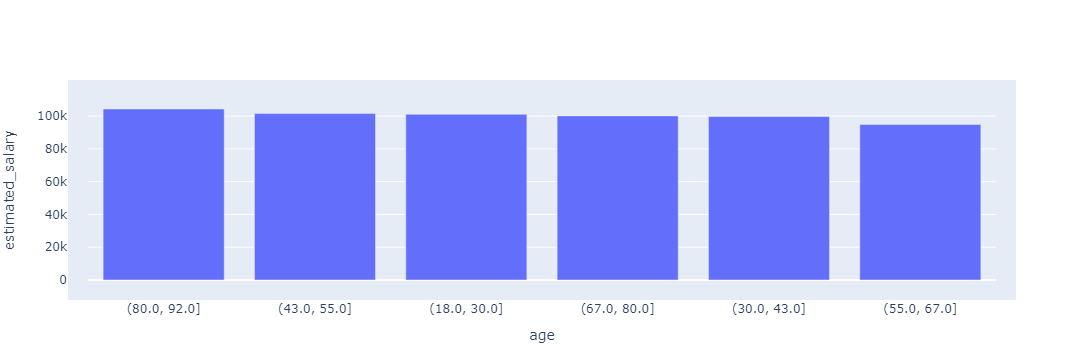

{'data': [{'x': ['(80.0, 92.0]',
    '(43.0, 55.0]',
    '(18.0, 30.0]',
    '(67.0, 80.0]',
    '(30.0, 43.0]',
    '(55.0, 67.0]'],
   'y': [104348.37866666666,
    101542.4664851958,
    101089.99995934959,
    100149.03508474577,
    99719.7547761775,
    94861.26503289473],
   'type': 'bar'}],
 'layout': {'template': {'data': {'histogram2dcontour': [{'type': 'histogram2dcontour',
      'colorbar': {'outlinewidth': 0, 'ticks': ''},
      'colorscale': [[0.0, '#0d0887'],
       [0.1111111111111111, '#46039f'],
       [0.2222222222222222, '#7201a8'],
       [0.3333333333333333, '#9c179e'],
       [0.4444444444444444, '#bd3786'],
       [0.5555555555555556, '#d8576b'],
       [0.6666666666666666, '#ed7953'],
       [0.7777777777777778, '#fb9f3a'],
       [0.8888888888888888, '#fdca26'],
       [1.0, '#f0f921']]}],
    'choropleth': [{'type': 'choropleth',
      'colorbar': {'outlinewidth': 0, 'ticks': ''}}],
    'histogram2d': [{'type': 'histogram2d',
      'colorbar': {'outlinewidth'

In [24]:
generate_plotly_graph(chart_config)